# Parameter fitting the Roche Model

## Generating epiabm data

In [1]:
import pyEpiabm as pe
import epimodels as em
import pandas as pd
import pints
# Load necessary libraries
import numpy as np
import epimodels as em
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten
np.random.seed(42)

In [2]:
# Define regions and extended age groups
regions = ['Luxembourg']
age_groups = ['0-20', '20-40', '40-60', '60-80', '80-100']

# Initial state of the system with an expanded contact data matrix
contact_data_matrix_0 = np.array([
    [10, 5.2, 4.5, 3.8, 2.1],
    [0, 3, 2.8, 2.5, 1.7],
    [1.2, 2.4, 3.5, 2.8, 1.5],
    [0.8, 1.9, 2.6, 3.2, 2.0],
    [0.5, 1.2, 1.7, 2.5, 3.0]
])

region_data_matrix_0_0 = np.array([
    [1, 10, 8, 6, 5],
    [1, 6, 5, 4, 3],
    [1, 5, 6, 5, 4],
    [1, 4, 5, 6, 5],
    [1, 3, 4, 5, 6]
])

contacts_0 = em.ContactMatrix(age_groups, contact_data_matrix_0)
regional_0_0 = em.RegionMatrix(regions[0], age_groups, region_data_matrix_0_0)

# Matrices contact
matrices_contact = [contacts_0]
time_changes_contact = [1]
matrices_region = [[regional_0_0]]
time_changes_region = [1]

# NPIs data
max_levels_npi = [3, 3, 3, 2, 2, 3, 2, 1, 3]  # All > 0
targeted_npi = [True, True, True, True, True, False, False, False, True]
general_npi = [
    [True] * 9,   # All on at day 1
    [True] * 9    # Continue at day 12
]
time_changes_flag = [1, 12]

reg_levels_npi = [[
    [3, 3, 3, 2, 2, 3, 2, 0, 3],  # Strong NPI: day 1–13
    [1, 1, 1, 1, 1, 1, 1, 0, 1]   # Moderate NPI: day 14–200
]]
time_changes_npi = [1, 14]

In [3]:
# Instantiate model
model = em.RocheSEIRModel()

# Set the region names, contact, and regional data of the model
model.set_regions(regions)
model.set_age_groups(age_groups)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)
model.read_npis_data(max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag)


mean = 38.90357303
variance = 521.1594572
std_dev = np.sqrt(variance)  # Standard deviation

# Generate 10000 samples from the normal distribution
samples = np.random.normal(mean, std_dev, 10000)

# Define bin edges for 9 equal bins
bin_edges = np.linspace(min(samples), max(samples), 6)

# Compute histogram
hist, _ = np.histogram(samples, bins=bin_edges, density=True)

# Convert counts to proportions
proportions = hist / hist.sum()

# Assume total population
total_population = 666430

# Scale the proportions to match the total population
scaled_population = (proportions * total_population).astype(int).tolist()

total_days=200

# Set ICs parameters
ICs = em.RocheICs(
    model=model,
    susceptibles_IC=[scaled_population],
    exposed_IC=[[100, 0, 0, 0, 0]],
    infectives_pre_IC=[[0, 0, 0, 0, 0]],
    infectives_asym_IC=[[0, 0, 0, 0, 0]],
    infectives_sym_IC=[[0, 0, 0, 0, 0]],
    infectives_pre_ss_IC=[[0, 0, 0, 0, 0]],
    infectives_asym_ss_IC=[[0, 0, 0, 0, 0]],
    infectives_sym_ss_IC=[[0, 0, 0, 0, 0]],
    infectives_q_IC=[[0, 0, 0, 0, 0]],
    recovered_IC=[[0, 0, 0, 0, 0]],
    recovered_asym_IC=[[0, 0, 0, 0, 0]],
    dead_IC=[[0, 0, 0, 0, 0]]
)
# Set average times in compartments
compartment_times = em.RocheCompartmentTimes(
    model=model,
    k=4.59,
    kS=0.5,
    kQ=1,
    kR= [7]*model._num_ages,
    kRI=[14]*model._num_ages
)

# Set proportion of asymptomatic, super-spreader, and dead cases
proportion_parameters = em.RocheProportions(
    model=model,
    Pa=0.34* np.ones(len(age_groups)),
    Pss=0.0,
    Pd=0.15 * np.ones(len(age_groups))
)

# Set transmission parameters
transmission_parameters = em.RocheTransmission(
    model=model,
    beta_min=0.01,
    beta_max=0.3,
    bss=2,
    gamma=1,
    s50=50
)

# Set other simulation parameters
simulation_parameters = em.RocheSimParameters(
    model=model,
    region_index=1,
    method='RK45',
    times=np.arange(1, total_days+1, 1).tolist()
)

# Set all parameters in the controller
parameters = em.RocheParametersController(
    model=model,
    ICs=ICs,
    compartment_times=compartment_times,
    proportion_parameters=proportion_parameters,
    transmission_parameters=transmission_parameters,
    simulation_parameters=simulation_parameters
)

# Simulate for the single region
parameters.simulation_parameters.region_index = 1

# Simulate using the ODE solver
output = model.simulate(parameters)

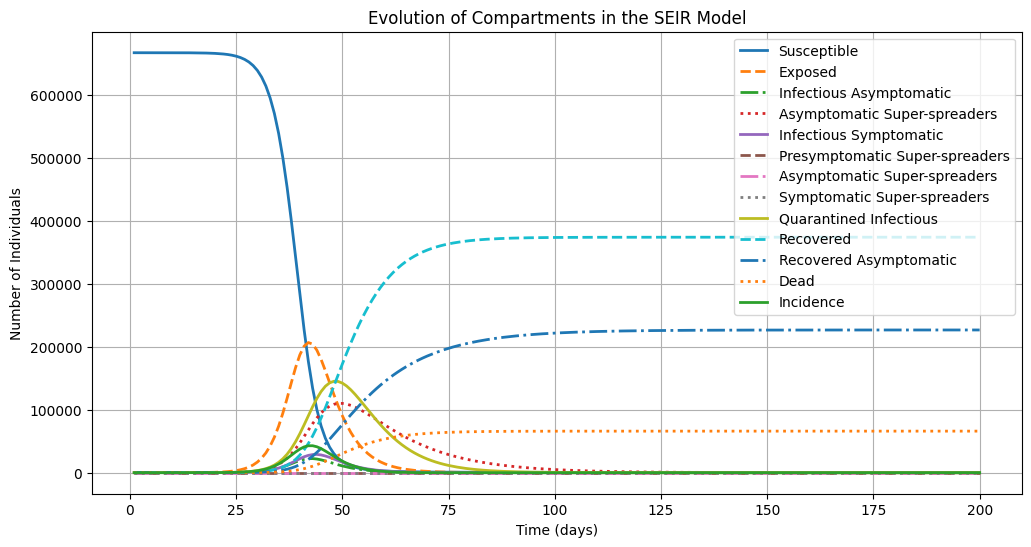

In [4]:
# Define compartments based on the RocheSEIRModel output structure
time_steps = np.array(parameters.simulation_parameters.times)
n_ages = model._num_ages


# Extract compartments
S = output[:, 0*n_ages:1*n_ages].sum(axis=1)
E = output[:, 1*n_ages:2*n_ages].sum(axis=1)
Ia = output[:, 2*n_ages:3*n_ages].sum(axis=1)
Iaa = output[:, 3*n_ages:4*n_ages].sum(axis=1)
Is = output[:, 4*n_ages:5*n_ages].sum(axis=1)
Ias = output[:, 5*n_ages:6*n_ages].sum(axis=1)
Iaas = output[:, 6*n_ages:7*n_ages].sum(axis=1)
Iss = output[:, 7*n_ages:8*n_ages].sum(axis=1)
Iq = output[:, 8*n_ages:9*n_ages].sum(axis=1)
R = output[:, 9*n_ages:10*n_ages].sum(axis=1)
Ra = output[:, 10*n_ages:11*n_ages].sum(axis=1)
D = output[:, 11*n_ages:12*n_ages].sum(axis=1)
Inc = output[:, 12*n_ages:13*n_ages].sum(axis=1)

# Plot all compartments on the same graph
plt.figure(figsize=(12, 6))

plt.plot(time_steps, S, label='Susceptible', linestyle='-', linewidth=2)
plt.plot(time_steps, E, label='Exposed', linestyle='--', linewidth=2)
plt.plot(time_steps, Ia, label='Infectious Asymptomatic', linestyle='-.', linewidth=2)
plt.plot(time_steps, Iaa, label='Asymptomatic Super-spreaders', linestyle=':', linewidth=2)
plt.plot(time_steps, Is, label='Infectious Symptomatic', linestyle='-', linewidth=2)
plt.plot(time_steps, Ias, label='Presymptomatic Super-spreaders', linestyle='--', linewidth=2)
plt.plot(time_steps, Iaas, label='Asymptomatic Super-spreaders', linestyle='-.', linewidth=2)
plt.plot(time_steps, Iss, label='Symptomatic Super-spreaders', linestyle=':', linewidth=2)
plt.plot(time_steps, Iq, label='Quarantined Infectious', linestyle='-', linewidth=2)
plt.plot(time_steps, R, label='Recovered', linestyle='--', linewidth=2)
plt.plot(time_steps, Ra, label='Recovered Asymptomatic', linestyle='-.', linewidth=2)
plt.plot(time_steps, D, label='Dead', linestyle=':', linewidth=2)
plt.plot(time_steps, Inc, label='Incidence', linestyle='-', linewidth=2)

# Labels and title
plt.xlabel('Time (days)')
plt.ylabel('Number of Individuals')
plt.title('Evolution of Compartments in the SEIR Model')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

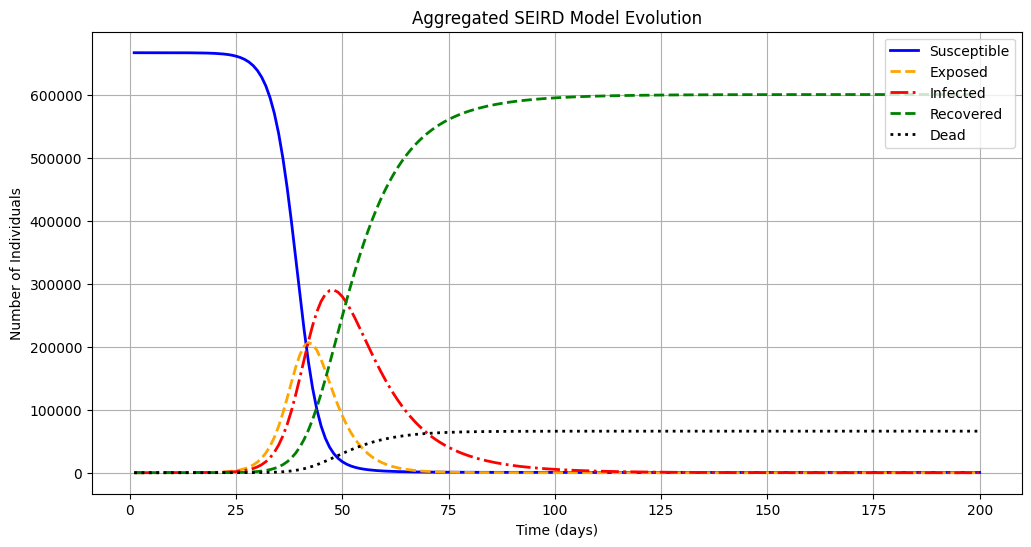

In [5]:
# Extract aggregated SEIRD compartments
S = output[:, 0*n_ages : 1*n_ages].sum(axis=1)   # Susceptible
E = output[:, 1*n_ages : 2*n_ages].sum(axis=1)   # Exposed
I = (
    output[:, 2*n_ages : 3*n_ages] +   # Ia
    output[:, 3*n_ages : 4*n_ages] +   # Iaa
    output[:, 4*n_ages : 5*n_ages] +   # Is
    output[:, 5*n_ages : 6*n_ages] +   # Ias
    output[:, 6*n_ages : 7*n_ages] +   # Iaas
    output[:, 7*n_ages : 8*n_ages] +   # Iss
    output[:, 8*n_ages : 9*n_ages]     # Iq
).sum(axis=1)  # Total Infected
R = output[:, 9*n_ages : 10*n_ages].sum(axis=1) + output[:, 10*n_ages : 11*n_ages].sum(axis=1)  # Total Recovered
D = output[:, 11*n_ages : 12*n_ages].sum(axis=1)  # Dead

# Plot SEIRD
plt.figure(figsize=(12, 6))

plt.plot(time_steps, S, label='Susceptible', linestyle='-', linewidth=2, color='blue')
plt.plot(time_steps, E, label='Exposed', linestyle='--', linewidth=2, color='orange')
plt.plot(time_steps, I, label='Infected', linestyle='-.', linewidth=2, color='red')
plt.plot(time_steps, R, label='Recovered', linestyle='--', linewidth=2, color='green')
plt.plot(time_steps, D, label='Dead', linestyle=':', linewidth=2, color='black')

# Labels and title
plt.xlabel('Time (days)')
plt.ylabel('Number of Individuals')
plt.title('Aggregated SEIRD Model Evolution')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

## Age

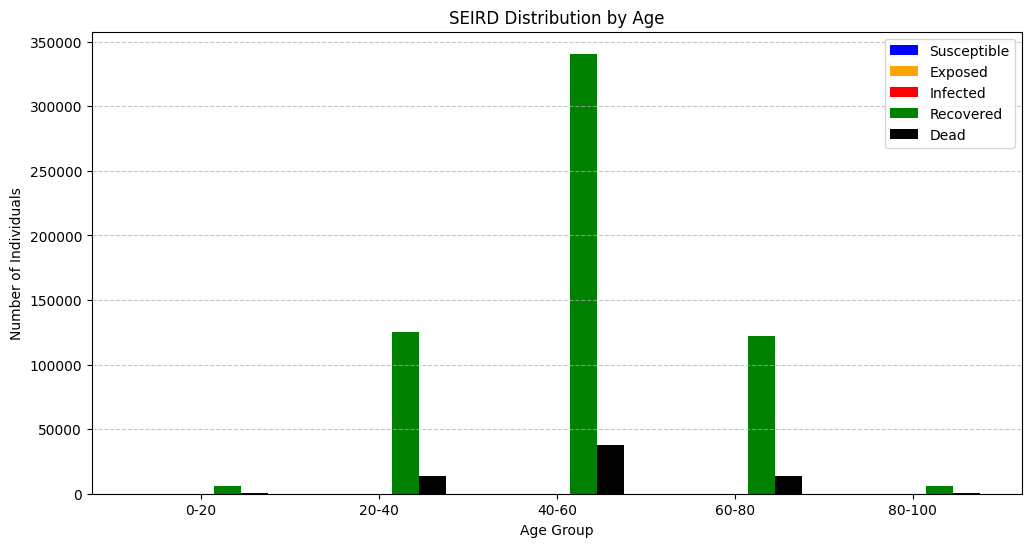

In [6]:
# Extract age groups
age_groups = parameters.model.age_groups_names()

# Aggregate SEIRD compartments by age
S_by_age = output[-1, :len(age_groups)]  # Susceptible at final time step
E_by_age = output[-1, len(age_groups):2*len(age_groups)]  # Exposed
I_by_age = np.sum(output[-1, 2*len(age_groups):9*len(age_groups)].reshape(7, len(age_groups)), axis=0)  # Total Infected
R_by_age = output[-1, 9*len(age_groups):10*len(age_groups)] + output[-1, 10*len(age_groups):11*len(age_groups)]  # Recovered
D_by_age = output[-1, 11*len(age_groups):12*len(age_groups)]  # Dead

# Create a DataFrame for visualization
df_seird_age = pd.DataFrame({
    'Age Group': age_groups,
    'Susceptible': S_by_age,
    'Exposed': E_by_age,
    'Infected': I_by_age,
    'Recovered': R_by_age,
    'Dead': D_by_age
})

# Plot SEIRD distribution by age
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width
bar_width = 0.15
index = np.arange(len(age_groups))

# Plot bars for each compartment
ax.bar(index, S_by_age, bar_width, label='Susceptible', color='blue')
ax.bar(index + bar_width, E_by_age, bar_width, label='Exposed', color='orange')
ax.bar(index + 2*bar_width, I_by_age, bar_width, label='Infected', color='red')
ax.bar(index + 3*bar_width, R_by_age, bar_width, label='Recovered', color='green')
ax.bar(index + 4*bar_width, D_by_age, bar_width, label='Dead', color='black')

# Labels and title
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Individuals')
ax.set_title('SEIRD Distribution by Age')
ax.set_xticks(index + 2*bar_width)
ax.set_xticklabels(age_groups)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Roche Inverse Problem

In [7]:
compartments = model.output_names()
compartment_data = {
    name: output[:, i*n_ages:(i+1)*n_ages].sum(axis=1)
    for i, name in enumerate(compartments)
}

df = pd.DataFrame(compartment_data)
df['Time'] = time_steps
df = df.set_index('Time')


### Inverse on Generated Data

In [8]:
# --- Extract simulated data ---
sens = 0.7
spec = 0.95

columns   = model.output_names()
num_ages  = model._num_ages
times     = np.arange(1, total_days + 1)  # [1, 2, …, total_days]

# `output` from your simulation has shape (T, C·A). Reshape to (T, C, A):
all_data = output.reshape((total_days, len(columns), num_ages))

# Round everything to the nearest integer
all_data = np.rint(all_data).astype(int)

# Pull out the S, Ia and cumulative D compartments
S_full  = all_data[:, columns.index('S'), :]   # shape (T, A), dtype=int
Ia_full = all_data[:, columns.index('Ia'), :]  # shape (T, A), dtype=int
D_cum   = all_data[:, columns.index('D'), :]   # cumulative deaths, dtype=int

# --- Compute observed *daily* deaths from the cumulative series ---
# 1) compute day‐to‐day differences
daily_deaths = np.diff(D_cum, axis=0)
# 2) prepend a row of zeros for day 1, and round into ints
D_obs = np.vstack([
    np.zeros((1, num_ages), dtype=int),
    np.rint(daily_deaths).astype(int)
])

# --- Build the data lists for inference ---

# 1) Initial‐condition lists: only time=1 (index 0)
susceptibles_ic = [S_full[0].tolist()]
infectives_ic   = [Ia_full[0].tolist()]

# 2) Deaths: daily counts at each t
deaths_data  = [D_obs]           # list of one array, shape (T, A), dtype=int
deaths_times = times.tolist()

# 3) Dummy serology: use ones (already ints)
tests_data     = [np.ones((len(times), num_ages), dtype=int)]
positives_data = [np.ones((len(times), num_ages), dtype=int)]
serology_times = times.tolist()

# --- Set up the inference object ---
infer = em.inference.RocheSEIRInfer(model)
infer.read_model_data(   susceptibles_ic, infectives_ic)
infer.read_deaths_data(  deaths_data,    deaths_times)
infer.read_serology_data(tests_data, positives_data, serology_times,
                         sens=sens, spec=spec)
infer.read_npis_data(    max_levels_npi, targeted_npi, general_npi,
                         reg_levels_npi, time_changes_npi, time_changes_flag)

# --- Sanity‐check log‐likelihood ---
x_test = [0.01, 2.0]                     # beta_min and bss
ll     = infer.return_loglikelihood(times.tolist(), x_test, wd=1, wp=0)
print('Log‐likelihood test =', ll)       # should now be finite, not -inf

"""
# --- Run full inference ---
samples = roche_inference.inference_problem_setup(
    times=times.tolist(),
    num_iter=500,
    wd=1,
    wp=0
)
"""

Log‐likelihood test = -inf


'\n# --- Run full inference ---\nsamples = roche_inference.inference_problem_setup(\n    times=times.tolist(),\n    num_iter=500,\n    wd=1,\n    wp=0\n)\n'

In [9]:
# … after you’ve set up:
#   model, ICs, compartment_times, proportion_parameters,
#   transmission_parameters, simulation_parameters
# and done:
#   parameters = RocheParametersController(...)
#   output        = model.simulate(parameters)

import numpy as np
from scipy.stats import nbinom
import pints

# 1) Pull out the “true” flat parameter vector from your controller:
flat_params = parameters()  # this is exactly what the simulator wants  

# 2) Sanity‐check the prior at your test point
x_test = [0.01, 2.0]  # [beta_min, bss]
lp  = pints.UniformLogPrior([0],[1])(x_test[0]) \
    + pints.UniformLogPrior([0],[10])(x_test[1])
print("log-prior =", lp)  
# should be finite (≈ –2.3026 because 1/10), not –∞

# 3) Overwrite the two “free” slots in the flat vector:
#    – beta_min is at flat_params[–6]
#    – bss      is at flat_params[–4]
flat_params[-6] = x_test[0]
flat_params[-4] = x_test[1]

# 4) Loop over your “death” days and ages and spot any zero‐μ with obs>0
deaths_arr  = np.asarray(deaths_data[0])    # shape (T_deaths, A)
death_days  = deaths_times                  

ν = 10**(-5)  # fixed over-dispersion in loglik

for idx, day in enumerate(death_days):
    k   = day - 1                          # zero-based index into ODE output
    # re‐simulate with your modified parameters
    sim  = model._simulate(parameters=flat_params, times=times.tolist())
    μ    = model.new_deaths(sim)[k, :]     # model mean deaths at day k

    obs  = deaths_arr[idx, :]              # your observed daily deaths
    obs = np.rint(obs).astype(int)
    n    = μ / ν
    p    = 1 / (1 + ν)
    lp_v = nbinom.logpmf(k=obs, n=n, p=p)

    bad  = np.isneginf(lp_v)
    if np.any(bad):
        print(f"day={day}, ages={np.where(bad)[0].tolist()}: μ={μ[bad]}, obs={obs[bad]} → logpmf={lp_v[bad]}")


log-prior = -2.302585092994046


In [10]:
import numpy as np
from scipy.stats import nbinom

# 1) Your test‐point for [beta_min, bss]
x_test = [0.01, 2.0]

# 2) Pull out the flat list once and overwrite the two free slots
flat_params = parameters()               # your RocheParametersController instance
flat_params[-6], flat_params[-4] = x_test

# 3) Re‐simulate with the patched parameters
times_list = times.tolist() if hasattr(times, "tolist") else list(times)
sim = model._simulate(flat_params, times_list)

# 4) Extract the model’s mean *daily* deaths (shape T×A)
mu = model.new_deaths(sim)

# 5) Prepare your observed deaths (round & cast to int)
obs = np.rint(deaths_data[0]).astype(int)

# 6) Compute the NB log‐pmf matrix
nu = 1e-5
n = mu / nu
p = 1 / (1 + nu)
ll_mat = nbinom.logpmf(obs, n=n, p=p)

# 7) Fix NaNs from SciPy when mu==0:
#    - if mu=0 and obs=0 ⇒ logpmf should be 0
#    - if mu=0 and obs>0 ⇒ logpmf should be -inf
zero_mu  = (mu == 0)
zero_obs = (obs == 0)
ll_mat = np.where(zero_mu & zero_obs,  0.0, ll_mat)
ll_mat = np.where(zero_mu & ~zero_obs, -np.inf, ll_mat)

# 8) Sum to get the total log‐likelihood
total_ll = np.sum(ll_mat)

print("manual log-likelihood =", total_ll)


manual log-likelihood = -1084.4659345254452


In [ ]:
import numpy as np
import pints
from scipy.stats import nbinom

# Define custom log-likelihood
def compute_loglik(x):
    flat = parameters()
    flat[-6], flat[-4] = x  # beta_min, bss
    model.read_npis_data(
    max_levels_npi,
    targeted_npi,
    general_npi,
    reg_levels_npi,
    time_changes_npi,
    time_changes_flag
)

    sim = model._simulate(flat, times.tolist())
    mu = model.new_deaths(sim)
    obs = np.rint(deaths_data[0]).astype(int)

    nu = 1e-5
    n = mu / nu
    p = 1 / (1 + nu)
    ll = nbinom.logpmf(obs, n=n, p=p)

    zero_mu  = (mu == 0)
    zero_obs = (obs == 0)
    ll = np.where(zero_mu & zero_obs,  0.0, ll)
    ll = np.where(zero_mu & ~zero_obs, -np.inf, ll)

    return np.sum(ll)

# Wrap in a PINTS LogPDF object
class ManualLogPDF(pints.LogPDF):
    def n_parameters(self): return 2
    def __call__(self, x):  return compute_loglik(x)

# Create log-likelihood and prior
loglik = ManualLogPDF()
prior  = pints.UniformLogPrior([0, 0], [1, 10])  # beta_min ∈ [0,1], bss ∈ [0,10]
posterior = pints.LogPosterior(loglik, prior)

# 2. Choose a starting point
x0 = [0.2, 3.0]  # [beta_min, bss], must be within prior bounds

# 3. Set up the optimiser with CMAES
opt = pints.OptimisationController(posterior, x0, method=pints.CMAES)

# 4. Optional: reduce verbosity
opt.set_log_to_screen(True)    # Show progress
opt.set_max_unchanged_iterations(100, threshold=1e-3)  # Stop if not improving

# 5. Run the optimiser
found_params, found_val = opt.run()

# 6. Output
print("Found parameters:", found_params)
print("Log-posterior value:", found_val)


Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6     -1243.6   -1243.6     0:01.2
1     12    -1243.6   -2838.38    0:02.2
2     18    -1243.6   -2084.273   0:03.0
3     24    -1243.6   -8149.236   0:03.9
20    126   -1086.769 -1086.769   0:19.8


In [ ]:
# Run inference
x0 = [0.2, 3.0]
controller = pints.MCMCController(posterior, 3, [x0]*3)
controller.set_max_iterations(10)

controller.set_log_to_screen(True)   # ← progress bar here
controller.set_log_to_file(None)     # ← suppress log file
controller.set_parallel(True)

print("Running...")
samples = controller.run()
print("Done! Shape =", samples.shape)
